## 00 Load Required Libraries and Functions

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image
from skimage.restoration import denoise_tv_chambolle
from scipy.ndimage import gaussian_filter
import os
from matplotlib.colors import ListedColormap
import scipy.ndimage as ndi 
import sys
sys.path.append(os.path.abspath('..'))


In [2]:
from functions import finding_defects as df
from functions import finetuning_training as utils

In [3]:
def sigmoid(x):
  return 1 / (1 + np.exp(-x))

## 01 Load models (final versions)

In [6]:
defect_finder_model = utils.load_model("../data/models/defect_finder300.tar")
lattice_finder_model = utils.load_model("../data/models/ensemble_lattice_finder_48160.pt")

5% indices  = 6, 22, 16
9% indices  = 0, 4, 20
12% indices = 4, 24, 1

(-0.5, 986.5, 986.5, -0.5)

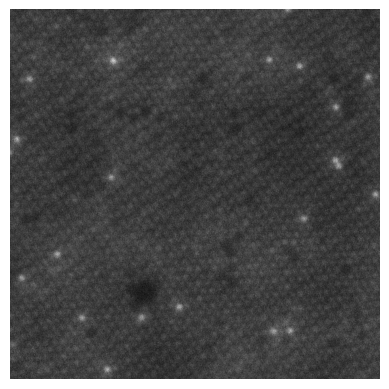

In [8]:
folder_path = "../data/images/12_5HF"
i = 1
images = df.load_tif_folder(folder_path)    
image = images[0][i]
w, h = image.size  
min_side = min(w, h)
left = (w - min_side) // 2
top = (h - min_side) // 2
right = left + min_side
bottom = top + min_side
image = image.crop((left, top, right, bottom))


plt.imshow(np.array(image), cmap='gray')
plt.axis('off')

Batch 1/1

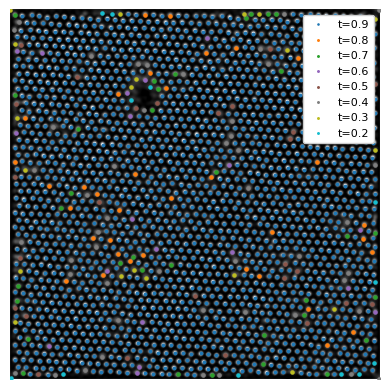

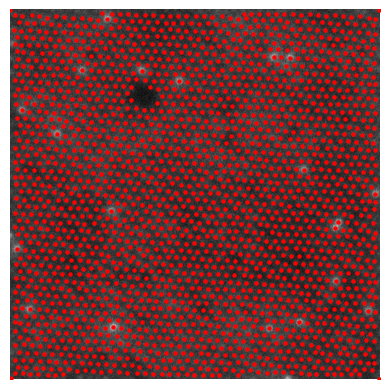

In [9]:
img_arr, mask1, stored_points, var = utils.get_total_points_ensemble(lattice_finder_model, images[0][i], plot= True, plot2 = True, normalize = True, t_values=[.9, .8, .7, .6, .5, .4, .3, .2])

Original Mask :


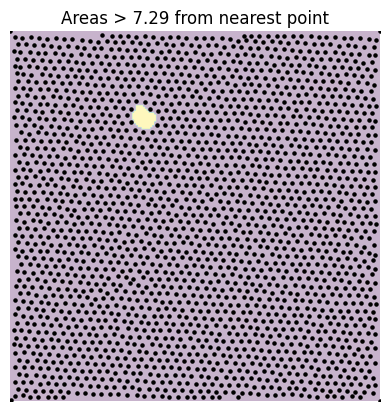

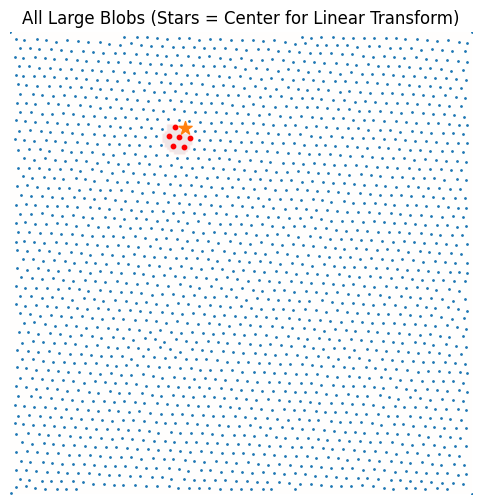

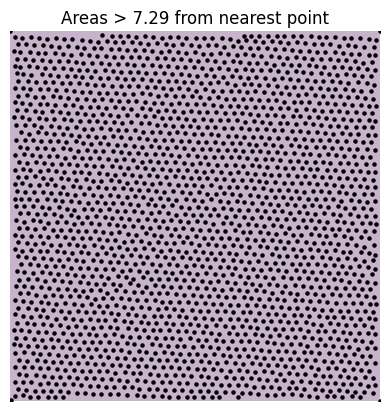

Final Dots located on Final Mask


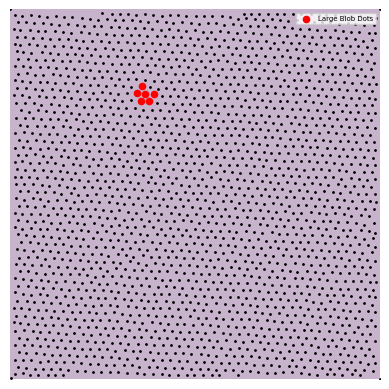

(array([], shape=(0, 2), dtype=float64),
 array([[192.39746245, 383.80070739],
        [180.71967802, 384.87374504],
        [198.91262344, 393.55133487],
        [187.23483901, 394.62437252],
        [175.55705458, 395.69741017],
        [182.07221557, 405.44803765]]))

In [10]:
df.iterative_atom_placement(stored_points, grid_size= 200, plot=True, seed = 42)

(-0.5, 511.5, -0.5, 511.5)

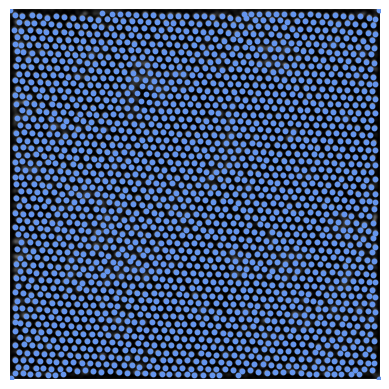

In [12]:
plt.imshow(mask1, cmap = "gray", origin = "lower")
plt.scatter(stored_points[:, 0], stored_points[:, 1], s=10, c='cornflowerblue', marker='o')
plt.axis('off')

In [13]:
from scipy.ndimage import binary_dilation


In [14]:
sigma=1.5
weight=0.001
im = Image.fromarray(denoise_tv_chambolle(gaussian_filter(image, sigma=sigma), weight=weight))


Batch 1/1
1 image was decoded in approximately 0.154 seconds


(-0.5, 511.5, 511.5, -0.5)

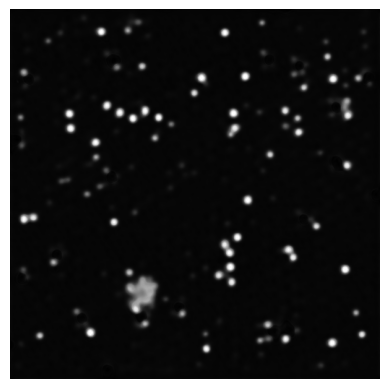

In [15]:
img_arr1, mask, stored_points_defect = utils.get_total_points(defect_finder_model,im, plot2=False)
low_thresh = 0.4
high_thresh = 0.65
min_pixels = 800
low_bin = mask >= low_thresh
labels, _ = ndi.label(low_bin)
sizes = np.bincount(labels.ravel())
keep  = sizes >= min_pixels
keep[0] = False
large = keep[labels]

small = mask >= high_thresh
prob = np.logical_or(large, small).astype(np.uint8)

mask_dil = binary_dilation(prob, iterations=3)   # expand each dot ~2 px

plt.imshow(mask, cmap='gray')
plt.axis('off')


(-0.5, 511.5, 511.5, -0.5)

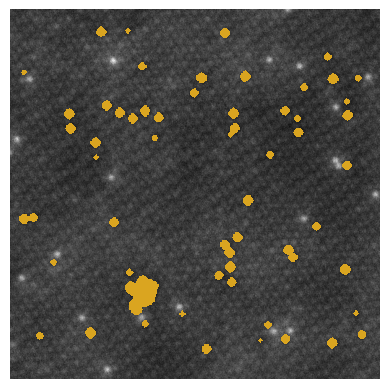

In [16]:
plt.imshow(img_arr, cmap='gray')                     # background

overlay = np.isclose(mask_dil, 1.0)                    # pixels to highlight
red_cmap = ListedColormap(['goldenrod'])                 # single-colour map

plt.imshow(
    np.ma.masked_where(~overlay, overlay),        
    cmap=red_cmap, vmin=0, vmax=1, alpha=1, interpolation='none'
)
plt.axis('off')

(-0.5, 511.5, 511.5, -0.5)

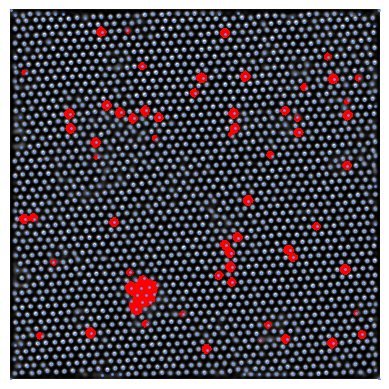

In [17]:
plt.imshow(mask1, cmap='gray')                     # background

overlay = np.isclose(mask_dil, 1.0)                    # pixels to highlight
red_cmap = ListedColormap(['red'])                 # single-colour map
plt.scatter(stored_points[:,0], stored_points[:,1], c='cornflowerblue', s=1, label='Predicted Points')

plt.imshow(
    np.ma.masked_where(~overlay, overlay),        
    cmap=red_cmap, vmin=0, vmax=1, alpha=1, interpolation='none'
)
plt.axis('off')

(-0.5, 511.5, 511.5, -0.5)

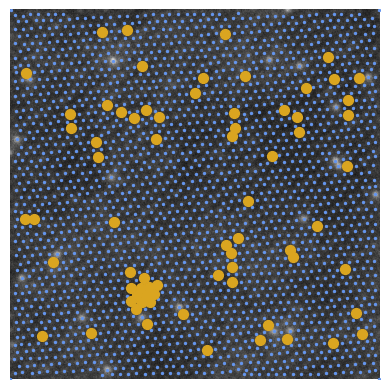

In [ ]:
h, w = mask_dil.shape
ix = stored_points[:, 0].astype(int).clip(0, w-1)
iy = stored_points[:, 1].astype(int).clip(0, h-1)

pts_red = stored_points[mask_dil[iy, ix]]

# draw
plt.imshow(img_arr, cmap='gray')
plt.scatter(stored_points[:, 0], stored_points[:, 1],
            c='cornflowerblue', s=2, label='Predicted Points')
plt.scatter(pts_red[:, 0], pts_red[:, 1],
            c='goldenrod', s=50, label='Points in red')
plt.axis('off')